In [1]:
import mindspore
# mindspore.set_context(device_target='CPU')
# mindspore.set_context(device_target='GPU')
mindspore.set_context(device_target="Ascend")
mindspore.set_context(device_id=0)
mindspore.run_check()

MindSpore version:  2.1.0
The result of multiplication calculation is correct, MindSpore has been installed on platform [Ascend] successfully!


# 7 指令微调

<img src="./images_llm/fig7.1.svg" width="600">

## 7.1 指令微调简介

- 预训练 LLM 的过程是一个逐词生成单词的训练过程。在这个过程中，模型通过预测下一个词来学习语言模式和知识，但这种训练方式并未明确教会模型如何理解和执行用户的特定指令。

- 预训练的LLM通常难以执行特定指令，因为它们主要学习的是语言的统计模式，而非如何响应用户的具体需求。例如，当被要求"总结这篇文章"或"用法语翻译这个句子"时，预训练模型可能会继续生成关于总结或翻译的文本，而不是执行实际的总结或翻译任务。

- 本章的核心目标是提高LLM遵循特定指令并生成所需响应的能力。通过指令微调，我们将教会模型识别指令、理解其含义，并生成符合指令要求的恰当回应，从而使模型更加实用和符合人类期望的交互方式。


<img src="./images_llm/fig7.2.svg" width="600">

本章涵盖的主题如图所示。

<img src="./images_llm/fig7.3.svg" width="600">

## 7.2 准备指令微调的数据集

为了进行指令微调，我们需要准备一个由指令-响应对组成的数据集。这些数据通常通过人工编写或从现有对话中提取而来，它们对于训练模型理解和执行各种类型的指令至关重要。高质量的指令数据集能够显著提升模型在各种任务上的表现能力。

In [2]:
import json
import os
import urllib

def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/Miao109/llm_mindspore/refs/heads/main/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


`data`列表中的每个条目时一个字典对象：

In [3]:

print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


`input`字段可以为空值：

In [4]:

print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


指令微调的过程是在指令数据集上对模型进行训练，这些数据集中明确提供了输入-输出对。这与传统预训练中简单预测下一个词的任务不同，指令微调要求模型学习理解指令的含义并给出适当的响应。有多种方法可以为LLM格式化这些条目。


<img src="./images_llm/fig7.4.svg" width="600">

定义一个format_input函数，用来将数据集中的条目格式化为Alpaca风格的输入样式。Alpaca是斯坦福大学开发的一种指令微调方法，其输入格式已被广泛采用：


In [5]:

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

格式化结果如下：

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


如果`input`字段为空值。

In [7]:

model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


先将数据集划分为训练集、验证集和测试集。在实际应用中，我们通常使用大部分数据进行训练，小部分用于验证和测试，以评估模型的泛化能力。这里我们使用85%的数据作为训练集，10%作为测试集，5%作为验证集。


In [8]:
# data = data[:100]
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [9]:

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 将数据组织成训练批次

有效的批处理是提高训练效率的关键。为了实现这一点，我们需要将数据转换为适合神经网络处理的格式，包括分词化和添加特殊标记等处理步骤。


<img src="./images_llm/fig7.5.svg" width="500">

批处理过程的实现包含五个子步骤：
1. 应用提示模板：将原始指令数据转换为结构化的提示格式
2. 分词化：将文本转换为模型能理解的数字ID序列
3. 添加填充标记：确保每个批次中的样本长度一致
4. 生成目标词元ID：创建模型应该预测的输出目标
5. 用一个占位符（如-100）替换损失函数中的填充标记：确保填充部分不影响模型学习

<img src="./images_llm/fig7.6.svg" width="600">

首先编写一个InstructionDataset类实现批处理过程的前两个步骤：使用特定的提示模板对条目进行格式化(2.1)，然后对其进行分词(2.2)，从而产生模型可以处理的词元ID序列。


<img src="./images_llm/fig7.7.svg" width="700">

In [10]:
import mindspore
# from torch.utils.data import Dataset
from mindspore.dataset import GeneratorDataset


class InstructionDataset:
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return [self.encoded_texts[index], ]
    
    def __len__(self):
        return len(self.data)

与分类微调一样，我们使用`<|endoftext|>`标记作为填充标记。这个特殊标记在GPT系列模型中用来表示文本的结束，同时也适合作为填充标记，因为它在预训练过程中就已经被模型学习过了。

In [11]:
from transformers import GPT2Tokenizer
# 指定本地词汇表文件所在的目录路径
local_path = "./gpt2-tokenizer"

# 从本地路径加载GPT - 2分词器
tokenizer = GPT2Tokenizer.from_pretrained(local_path)
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


[50256]


我们可以开发一个自定义的collate函数执行流程中的填充步骤，该函数可传递给数据加载器。这个自定义collate函数将每个批次中的训练示例填充到相同的长度，允许不同批次具有不同的长度，这样可以减少不必要的计算资源浪费。

<img src='./images_llm/fig7.8.svg' width="700">

In [12]:
import numpy
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    # device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = padded[:-1]
        inputs_lst.append(inputs)
    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = numpy.stack(inputs_lst)
    return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

[[    0     1     2     3     4]
 [    5     6 50256 50256 50256]
 [    7     8     9 50256 50256]]


<img src='./images_llm/fig7.9.svg' width="600">

上述自定义collate函数可用于从输入数据中创建批次数据。为了训练模型并计算损失以更新权重，我们还需要创建与输入ID批次相对应的目标词元ID批次。在语言模型训练中，目标通常是输入序列向右偏移一个位置的结果，这是因为模型的任务是预测序列中的下一个词元。

<img src='./images_llm/fig7.10.svg' width="600">

In [14]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = padded[:-1]  # Truncate the last token for inputs
        targets = padded[1:]  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = numpy.stack(inputs_lst)
    targets_tensor = numpy.stack(targets_lst)
    return inputs_tensor, targets_tensor

In [15]:

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

[[    0     1     2     3     4]
 [    5     6 50256 50256 50256]
 [    7     8     9 50256 50256]]
[[    1     2     3     4 50256]
 [    6 50256 50256 50256 50256]
 [    8     9 50256 50256 50256]]


下一步，我们需要为所有填充标记分配一个-100占位符(ignore_index)。在计算损失时，这个特殊值能够将这些填充标记有效地排除在外，确保只有有意义的数据才会对模型的学习过程产生影响。这一步非常重要，因为如果不排除填充标记，模型会浪费资源学习预测填充标记，而这并不是我们期望的行为。

<img src="./images_llm/fig7.11.svg" width="600">

这里在目标列表中保留了一个文本结束标记，ID为50256。保留这个标记的目的是让LLM学习何时根据指令生成文本结束标记，我们将其视为生成的响应已完成的指标。这对于实际应用中控制模型输出长度非常重要。

<img src="./images_llm/fig7.12.svg" width="600">

In [16]:
import numpy as np
def custom_collate_fn(
    batch, batchinfo=None,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item) + 1 for item in batch)
    # print("batch_max_length:", batch_max_length)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item = np.pad(new_item, (0, 1), constant_values=pad_token_id)
        padding_length = batch_max_length - len(new_item)
        padded = np.pad(new_item, (0, padding_length), mode="constant", constant_values=pad_token_id)
        padded = padded.tolist()
        inputs = np.array(padded[:-1])  # Truncate the last token for inputs
        targets = np.array(padded[1:])  # Shift +1 to the right for targets

        mask = (targets == pad_token_id)
        indices = np.nonzero(mask)[0]
        num = indices.size
        if num > 1:
            for i in indices[1:]:
                targets[i] = ignore_index
        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
        # inputs_lst = ops.stack(inputs_lst)
        # targets_lst = ops.stack(targets_lst)
    return np.array(inputs_lst), np.array(targets_lst)

In [17]:

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

[[    0     1     2     3     4]
 [    5     6 50256 50256 50256]
 [    7     8     9 50256 50256]]
[[    1     2     3     4 50256]
 [    6 50256  -100  -100  -100]
 [    8     9 50256  -100  -100]]


为了更直观地演示，考虑以下示例：

In [18]:
import mindspore.ops as ops
logits_1 = mindspore.Tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = mindspore.Tensor([0, 1])


loss_1 = ops.cross_entropy(logits_1, targets_1)
print(loss_1)

1.1269281


添加第三个示例文本后，得到的损失值为 0.7936。

In [19]:

logits_2 = mindspore.Tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = mindspore.Tensor([0, 1, 1])

loss_2 = ops.cross_entropy(logits_2, targets_2)
print(loss_2)

0.7935948


In [20]:
targets_3 = mindspore.Tensor([0, 1, -100])

loss_3 = ops.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

1.1269281
loss_1 == loss_3: True


交叉熵函数`cross_entropy`中的参数`ignore_index`的值默认为$-100$，这一设置使得函数在计算损失时，会自动忽略所有被标记为$-100$的目标值。这个特性允许我们在计算损失时只关注那些有意义的预测，而不是浪费计算资源在填充标记上。

除了屏蔽填充标记之外，屏蔽与指令相对应的目标词元ID也很常见。通过屏蔽与指令相对应的LLM目标词元ID，交叉熵损失仅针对生成的响应目标ID进行计算。因此，模型被训练为专注于生成准确的响应而不是记忆指令，这有助于减少过度拟合，提高模型在新指令上的泛化能力。

<img src="./images_llm/fig7.13.svg" width="700">

## 7.4 创建数据加载器

数据加载器负责将数据以批次的形式提供给模型进行训练，它是连接数据处理和模型训练的重要桥梁。通过适当配置数据加载器，我们可以实现数据的高效加载和处理。

<img src="./images_llm/fig7.14.svg" width="500">

functools.partial 可以​“冻结”函数的部分参数，生成一个新的简化版函数。新函数在调用时，可以省去重复传递这些已固定的参数。这在数据加载过程中特别有用，可以保持代码的简洁性。

In [21]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    allowed_max_length=1024
)

In [22]:

num_workers = 1
batch_size = 8

# mindspore.set_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = GeneratorDataset(train_dataset,  ["input_ids"], shuffle=True)
train_loader = train_loader.batch(
    batch_size=batch_size,
    per_batch_map=customized_collate_fn,
    drop_remainder=True,
    num_parallel_workers=num_workers,
    output_columns=["input_ids", "target_ids"]
)

In [23]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = GeneratorDataset(val_dataset, ['input_ids'], shuffle=False)
val_loader = val_loader.batch(
    batch_size=batch_size,
    per_batch_map=customized_collate_fn,
    drop_remainder=False,
    num_parallel_workers=num_workers,
    output_columns=["input_ids", "target_ids"]
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = GeneratorDataset(val_dataset, ['input_ids'], shuffle=False)
test_loader = test_loader.batch(
    batch_size=batch_size,
    per_batch_map=customized_collate_fn,
    drop_remainder=False,
    num_parallel_workers=num_workers,
    output_columns=["input_ids", "target_ids"]
)

检查一下加载器生成的输入和目标批次的维度：

In [24]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
(8, 77) (8, 77)
(8, 67) (8, 67)
(8, 68) (8, 68)
(8, 69) (8, 69)
(8, 65) (8, 65)
(8, 64) (8, 64)
(8, 61) (8, 61)
(8, 66) (8, 66)
(8, 64) (8, 64)
(8, 61) (8, 61)
(8, 80) (8, 80)
(8, 62) (8, 62)
(8, 62) (8, 62)
(8, 83) (8, 83)
(8, 60) (8, 60)
(8, 65) (8, 65)
(8, 65) (8, 65)
(8, 72) (8, 72)
(8, 70) (8, 70)
(8, 65) (8, 65)
(8, 70) (8, 70)
(8, 68) (8, 68)
(8, 62) (8, 62)
(8, 75) (8, 75)
(8, 75) (8, 75)
(8, 64) (8, 64)
(8, 61) (8, 61)
(8, 72) (8, 72)
(8, 74) (8, 74)
(8, 64) (8, 64)
(8, 76) (8, 76)
(8, 60) (8, 60)
(8, 82) (8, 82)
(8, 63) (8, 63)
(8, 67) (8, 67)
(8, 83) (8, 83)
(8, 68) (8, 68)
(8, 69) (8, 69)
(8, 61) (8, 61)
(8, 73) (8, 73)
(8, 83) (8, 83)
(8, 56) (8, 56)
(8, 76) (8, 76)
(8, 65) (8, 65)
(8, 83) (8, 83)
(8, 61) (8, 61)
(8, 64) (8, 64)
(8, 69) (8, 69)
(8, 68) (8, 68)
(8, 71) (8, 71)
(8, 75) (8, 75)
(8, 62) (8, 62)
(8, 77) (8, 77)
(8, 69) (8, 69)
(8, 76) (8, 76)
(8, 80) (8, 80)
(8, 88) (8, 88)
(8, 60) (8, 60)
(8, 71) (8, 71)
(8, 68) (8, 68)
(8, 62) (8, 62)
(8, 70) (8

In [25]:
print(inputs[0])

[21106   318   281 12064   326  8477   257  4876    13 19430   257  2882
   326 20431 32543   262  2581    13   198   198 21017 46486    25   198
  8645   378   257  6827  1262   262  1573   705   325 10920   541   414
  2637   198   198 21017 18261    25   198 36276   262  7104 10481   373
  5899   384 10920   541   414    13 50256 50256 50256 50256 50256 50256
 50256 50256 50256 50256 50256 50256 50256 50256 50256]


In [26]:
print(targets[0])

[  318   281 12064   326  8477   257  4876    13 19430   257  2882   326
 20431 32543   262  2581    13   198   198 21017 46486    25   198  8645
   378   257  6827  1262   262  1573   705   325 10920   541   414  2637
   198   198 21017 18261    25   198 36276   262  7104 10481   373  5899
   384 10920   541   414    13 50256  -100  -100  -100  -100  -100  -100
  -100  -100  -100  -100  -100  -100  -100  -100  -100]


## 7.5 加载预训练模型

指令微调是建立在预训练模型基础上的，因此我们需要先加载一个已经经过大规模预训练的模型，然后在此基础上进行微调。这种方法能够有效利用预训练模型已经学到的语言知识，大大减少了训练所需的计算资源和数据量。

<img src="./images_llm/fig7.15.svg" width="500">

In [27]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)


[WARNING] ME(309179:281472827042672,MainProcess):2025-03-13-21:25:48.665.785 [mindspore/nn/layer/basic.py:171] This parameter `dtype` will be deleted or invisible in the future. Please don't use it.


In [28]:
load_weights_into_gpt(model, params)
model.set_train(False)

GPTModel<
  (tok_emb): Embedding<vocab_size=50257, embedding_size=1024, use_one_hot=False, embedding_table=Parameter (name=embedding_table, shape=(50257, 1024), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (pos_emb): Embedding<vocab_size=1024, embedding_size=1024, use_one_hot=False, embedding_table=Parameter (name=embedding_table, shape=(1024, 1024), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (drop_emb): Dropout<p=0.0>
  (trf_blocks): SequentialCell<
    (0): TransformerBlock<
      (att): MultiHeadAttention<
        (W_query): Dense<input_channels=1024, output_channels=1024, has_bias=True>
        (W_key): Dense<input_channels=1024, output_channels=1024, has_bias=True>
        (W_value): Dense<input_channels=1024, output_channels=1024, has_bias=True>
        (out_proj): Dense<input_channels=1024, output_channels=1024, has_bias=True>
        (dropout): Dropout<p=0.0>
        >
      (ff): FeedForward<
        (layers): SequentialCel

In [29]:
# mindspore.set_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [30]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)


def token_ids_to_text(token_ids, tokenizer):
     # 检查是否有批量维度，如果有则移除
    if len(token_ids.shape) > 1 and token_ids.shape[0] == 1:
        flat = token_ids.squeeze(0)
    else:
        flat = token_ids
    # flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


generate 函数返回的是输入和输出文本的组合。由于预训练的 LLM 主要设计为文本续写，输入和输出连接在一起可以形成一个连贯且清晰的文本。但是，在特定任务上评估模型的表现时，我们通常只想关注模型生成的响应。

为了单独获取模型的响应文本，我们需要从`generated_text`的总长度中去除输入指令：

In [31]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


可以看到，微调前的模型还未能正确理解和执行指令，只是简单地复述了部分输入文本。这正是我们需要进行指令微调的原因。

## 7.6 指令微调

现在我们已经准备好了数据和模型，可以开始进行指令微调过程。通过微调，模型将学习如何识别指令并生成合适的响应，从而更好地满足用户需求。

<img src="./images_llm/fig7.16.svg" width="500">

In [35]:
from mindspore import value_and_grad
def calc_loss_loader(data_loader, model, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches
def calc_loss_batch(input_batch, target_batch, model):
    logits = model(input_batch)
    loss = ops.cross_entropy(ops.flatten(logits, start_dim=0, end_dim=1), target_batch.flatten())
    return loss
def evaluate_model(model, train_loader, val_loader, eval_iter):
    model.set_train(False)
    train_loss = calc_loss_loader(train_loader, model, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, num_batches=eval_iter)
    model.set_train(True)
    return train_loss, val_loss
def train_model_simple(model, train_loader, val_loader, optimizer, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    # 定义前向传播函数
    def forward_fn(input_batch, target_batch):
        loss = calc_loss_batch(input_batch, target_batch, model)
        return loss
    
    # 获取计算梯度的函数
    grad_fn = value_and_grad(forward_fn, None, optimizer.parameters)

    # Main training loop
    for epoch in range(num_epochs):
        model.set_train(True)  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            # loss = calc_loss_batch(input_batch, target_batch, model)
            # 计算损失和梯度
            loss, grads = grad_fn(input_batch, target_batch)
            # 使用优化器更新参数
            optimizer(grads)

            # loss.backward() # Calculate loss gradients
            # optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss.asnumpy():.3f}, Val loss {val_loss.asnumpy():.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, start_context
        )

    return train_losses, val_losses, track_tokens_seen
def generate_and_print_sample(model, tokenizer, start_context):
    model.set_train(False)
    context_size = model.pos_emb.embedding_table.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer)
    token_ids = generate_text_simple(
        model=model, idx=encoded,
        max_new_tokens=50, context_size=context_size
    )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.set_train(True)
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        # with mindspore.context.grad_off():
        logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        softmax = ops.Softmax(axis=-1)
        probas = softmax(logits)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = ops.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = ops.concat((idx, idx_next), axis=1)  # (batch, n_tokens+1)

    return idx


In [36]:
train_loss = calc_loss_loader(train_loader, model, num_batches=5)
val_loss = calc_loss_loader(val_loader, model, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.720142
Validation loss: 3.7619357


我们设置一个合理的学习率和权重衰减值来进行微调。对于指令微调任务，通常使用较小的学习率（如0.00005）以避免破坏预训练模型已经学到的知识。同时，添加适当的权重衰减（如0.1）可以防止模型过度拟合训练数据。

微调过程中，我们会定期评估模型在训练集和验证集上的表现，以监控训练进度并防止过拟合。此外，我们还会在每个训练周期结束后生成一个示例，直观地观察模型响应指令的能力是否有所提升。

In [ ]:
import time

import mindspore.nn as nn
start_time = time.time()

# optimizer = nn.AdamWeightDecay(model.trainable_params(), learning_rate=0.00005, weight_decay=0.1)
optimizer = nn.Adam(model.trainable_params(), learning_rate=0.00005)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
print(train_losses, val_losses)

Ep 1 (Step 000000): Train loss 2.729, Val loss 2.663


[WARNING] GE_ADPT(260517,ffff8d497b70,python):2025-03-13-21:11:54.001.760 [mindspore/ccsrc/transform/graph_ir/utils.cc:70] FindAdapter] Can't find OpAdapter for GatherDGradV2


Ep 1 (Step 000005): Train loss 2.028, Val loss 2.079
Ep 1 (Step 000010): Train loss 2.053, Val loss 2.055


[WARNING] GE_ADPT(260517,ffff8d497b70,python):2025-03-13-21:16:18.693.998 [mindspore/ccsrc/transform/graph_ir/utils.cc:70] FindAdapter] Can't find OpAdapter for GatherDGradV2
[WARNING] GE_ADPT(260517,ffff8d497b70,python):2025-03-13-21:16:24.781.039 [mindspore/ccsrc/transform/graph_ir/utils.cc:70] FindAdapter] Can't find OpAdapter for GatherDGradV2


Ep 1 (Step 000015): Train loss 2.073, Val loss 2.061


[WARNING] GE_ADPT(260517,ffff8d497b70,python):2025-03-13-21:18:06.292.810 [mindspore/ccsrc/transform/graph_ir/utils.cc:70] FindAdapter] Can't find OpAdapter for GatherDGradV2


Ep 1 (Step 000020): Train loss 2.141, Val loss 2.108
Ep 1 (Step 000025): Train loss 2.211, Val loss 2.218


[WARNING] GE_ADPT(260517,ffff8d497b70,python):2025-03-13-21:22:24.830.252 [mindspore/ccsrc/transform/graph_ir/utils.cc:70] FindAdapter] Can't find OpAdapter for GatherDGradV2


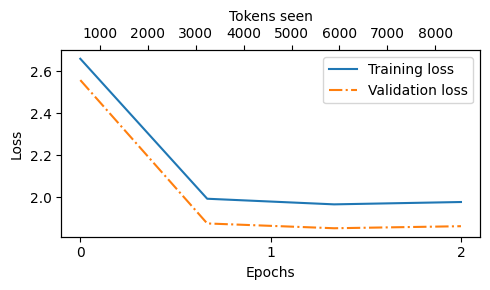

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = ops.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 7.7 提取并保存模型响应

完成微调后，我们需要评估模型的表现，并将训练好的模型保存起来以便未来使用。评估通常包括对测试集数据的定量和定性分析。

<img src="./images_llm/fig7.17.svg" width="500">

In [32]:
from gpt_model import GPTModel
import mindspore

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

model = GPTModel(BASE_CONFIG)

param_dict = mindspore.load_checkpoint("model_instruction_sft.ckpt")
param_not_load, _ = mindspore.load_param_into_net(model, param_dict)
print(param_not_load)

[WARNING] ME(309179:281472827042672,MainProcess):2025-03-13-21:28:07.281.974 [mindspore/train/serialization.py:170] The type of trf_blocks.0.att.mask:Float64 in 'parameter_dict' is different from the type of it in 'net':Float32, then the type convert from Float64 to Float32 in the network.
[WARNING] ME(309179:281472827042672,MainProcess):2025-03-13-21:28:07.341.971 [mindspore/train/serialization.py:170] The type of trf_blocks.1.att.mask:Float64 in 'parameter_dict' is different from the type of it in 'net':Float32, then the type convert from Float64 to Float32 in the network.
[WARNING] ME(309179:281472827042672,MainProcess):2025-03-13-21:28:07.404.846 [mindspore/train/serialization.py:170] The type of trf_blocks.2.att.mask:Float64 in 'parameter_dict' is different from the type of it in 'net':Float32, then the type convert from Float64 to Float32 in the network.
[WARNING] ME(309179:281472827042672,MainProcess):2025-03-13-21:28:07.466.093 [mindspore/train/serialization.py:170] The type of

[]


In [33]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)
from transformers import GPT2Tokenizer

# 指定本地词汇表文件所在的目录路径
local_path = "./gpt2-tokenizer"

# 从本地路径加载GPT - 2分词器
tokenizer = GPT2Tokenizer.from_pretrained(local_path)

In [34]:
for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.
Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A type of cloud is typically associated with thunderstorms.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane Austen.
-------------------------------------


In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

在实际应用中，指令微调后的模型相比原始预训练模型，通常表现出显著更强的指令理解和执行能力。这种改进使得模型能够更好地应对实际应用场景中的各种任务要求，为用户提供更有价值的服务。

最后，我们需要将训练好的模型保存下来，以便在未来直接加载使用，而无需重新进行训练。这不仅节省了计算资源，也使得模型能够更方便地部署到生产环境中。

In [35]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.'}


In [ ]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
mindspore.save_checkpoint(model, file_name)
print(f"Model saved as {file_name}")